In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [2]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
lag = 41
process = 2


In [30]:
summary_paths = [f'../{protein}/summary_batch1.h5', f'../{protein}/summary_batch2.h5', f'../{protein}/summary_batch3.h5']

hp_paths = ['../../experiments/hpsample.h5', '../../experiments/new_hpsample.h5', '../../experiments/new_ts_hpsample_missing_best.h5']

keep_hp_ixs = [np.array([]), np.array([329, 330, 331, 334, 335]), 
               np.array([340, 341, 342, 343, 344])]

hps = []
timescales = []

for batch_num in range(3):
    keep_ix = keep_hp_ixs[batch_num]
    
    # Hp definitions
    hp = pd.read_hdf(hp_paths[batch_num])
    hp.reset_index(inplace=True)    
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in hp.columns:
            hp.drop(labels=[drop_col], inplace=True, axis=1)
    if keep_ix.shape[0]>0: 
        hp = hp.loc[hp.hp_ix.isin(keep_ix), :]
    hps.append(hp)
    
    # timescales
    tmp = pd.read_hdf(summary_paths[batch_num], key='timescales')
    tmp.reset_index(inplace=True)
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in tmp.columns:
            tmp.drop(labels=[drop_col], inplace=True, axis=1)
    
    if keep_ix.shape[0]>0: 
        tmp = tmp.loc[tmp.hp_ix.isin(keep_ix), :]
    timescales.append(tmp)
    
       
timescales = pd.concat(timescales, axis=0)
hps = pd.concat(hps, axis=0)    

print(timescales.shape, hps.shape)

timescales = timescales.merge(hps, on=['hp_ix'], how='left')
timescales['feature'] = timescales.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)
print(timescales.shape)
timescales.drop_duplicates(inplace=True)
print(timescales.shape)

(68161, 7) (150, 14)
(68161, 21)
(68161, 21)


In [31]:
data=timescales.query("process==2").query('lag==41')
data.sort_values(by='median', inplace=True, axis=0, ascending=False)
data['rank'] = (np.arange(data.shape[0])+1).astype(int)

In [32]:
short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}

def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x

data['feature'] = data['feature'].apply(f)
timescales['feature'] = timescales['feature'].apply(f)

In [56]:
groups = [timescales.hp_ix[timescales.hp_ix < 329].unique()] + keep_hp_ixs[1:] + [timescales.hp_ix[(timescales.hp_ix < 329) & (timescales.hp_ix != 24)].unique()]
groups

[array([ 28, 216, 182, 195, 199, 242, 206,  43, 269, 135, 121,  17, 272,
         32,  19, 101,  73,  15,  44, 104,  31,  67, 111, 102, 264, 106,
        184, 262, 202,  35, 175,  37,  47, 162,   4, 197,  86, 321, 176,
         10,  69, 289, 208, 140,  30, 328,   9, 139, 144,  39, 260,  91,
        120,  60, 194, 145,  42,  55, 174,   0, 124,  81, 118,  13,  85,
         40, 170, 311, 171,   7,  34, 133,  23, 123,  93,   5, 183, 157,
         78, 192, 227, 193, 150,  21,  18,  33,  22, 235,  83,  74,  20,
        131, 186,  72, 241,   6,  27, 217, 254, 113, 207,  12,  29,  89,
        167, 198, 313, 129,  57, 112,  16,  26,   8,  68, 278, 130, 228,
         87, 239,  24,  14, 230, 291,   2,  25, 147,  54,   1,  38,  88,
         11, 295, 151,  36, 117,   3]),
 array([329, 330, 331, 334, 335]),
 array([340, 341, 342, 343, 344]),
 array([ 28, 216, 182, 195, 199, 242, 206,  43, 269, 135, 121,  17, 272,
         32,  19, 101,  73,  15,  44, 104,  31,  67, 111, 102, 264, 106,
        184, 2

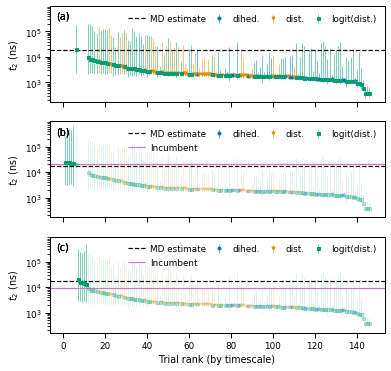

In [70]:
with sns.plotting_context('paper', font_scale=1):
    cols = sns.color_palette('colorblind')
    shapes = ['o', 'v', 's']
    
    
    hp_ix_cutoff = 329 # the indices where the optimized trials start
    incumbent_1 = -np.inf
    incumbent_2 = -np.inf
    
    
    fig, axes = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(6, 6))
    for i, feat in enumerate(np.sort(timescales.feature.unique())): 
        
        
        # Pre optimization
        group_num = 0
        ax = axes[group_num]
        
        ix = (data.feature==feat) & (data.hp_ix.isin(groups[group_num]))
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], markersize=3, color=cols[i], label=feat)
        
        ax.set_ylabel('$t_{2}$ (ns)')
        ax.set_yscale('log')
        
        ax.annotate(text="(a)", xy=(0.02, 0.95), xycoords='axes fraction', ha='left', va='top')
        

         # Post optimization
        group_num=1
        ax = axes[group_num]
        ix = (data.feature==feat) & (data.hp_ix.isin(groups[group_num]))
                                     
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], markersize=3, color=cols[i], label=feat)

            
        
        ix = (data.feature==feat) & (data.hp_ix.isin(groups[0])) 
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], 
                    markersize=3, color=cols[i], alpha=0.25)
        
        if np.max(y)>incumbent_1: 
            incumbent_1 = np.max(y)
        
        
        # ax.set_xlabel('Trial rank (by timescale)')
        ax.set_ylabel('$t_{2}$ (ns)')
        ax.set_yscale('log')       
        
        ax.annotate(text="(b)", xy=(0.02, 0.95), xycoords='axes fraction', ha='left', va='top')
        
        
        
        # Post optimization without best result
        group_num=2
        ax = axes[group_num]
        ix = (data.feature==feat) & (data.hp_ix.isin(groups[group_num]))
                                     
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], markersize=3, color=cols[i], label=feat)

        
        ix = (data.feature==feat) & (data.hp_ix.isin(groups[3])) 
        y = data.loc[ix, 'median']
        yerr = (y-data.loc[ix, 'lb'], data.loc[ix, 'ub']-y)
        x = data.loc[ix, 'rank']
        ax.errorbar(x, y, yerr, elinewidth=0.5, lw=0, marker=shapes[i], 
                    markersize=3, color=cols[i], alpha=0.25)
        
        if np.max(y)>incumbent_2: 
            incumbent_2 = np.max(y)
            
        ax.set_xlabel('Trial rank (by timescale)')
        ax.set_ylabel('$t_{2}$ (ns)')
        ax.set_yscale('log')       
        
        ax.annotate(text="(c)", xy=(0.02, 0.95), xycoords='axes fraction', ha='left', va='top')
        
                                                 
        
    incumbents = [None, incumbent_1, incumbent_2]
    
    for i, ax in enumerate(axes.flatten()): 
        xlim = ax.get_xlim()
        ax.hlines(md_t2[protein], xlim[0], xlim[1], ls='dashed', color='k', label='MD estimate')
        inc = incumbents[i]
        if inc is not None: 
            ax.hlines(inc, xlim[0], xlim[1], ls='solid', color=cols[4], label='Incumbent')
        ax.set_xlim(xlim)
        
    for ax in axes:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=4, 
                   frameon=False, handletextpad=0.5,  columnspacing=0.5)

    
    plt.savefig(f'../{protein}/{protein}_timescales.pdf', bbox_inches='tight')

In [71]:
data.sort_values(by='median', ascending=False).loc[:, ['median', 'hp_ix','distances__scheme', 'tica__dim', 'tica__lag', 'cluster__k', 'distances__steepness', 'distances__centre']].head(12)

,median,hp_ix,distances__scheme,tica__dim,tica__lag,cluster__k,distances__steepness,distances__centre
64511,24112.350456,331,ca,17,38,459,5.967568,0.700806
65061,24002.430197,329,ca,17,38,469,5.967568,0.700806
63961,23675.080545,335,ca,19,38,479,5.967568,0.700806
62861,23363.471334,330,ca,17,38,479,5.967568,0.700806
63411,22371.078033,334,ca,18,38,479,5.967568,0.700806
54876,20430.946382,24,ca,20,60,471,6.081760,0.224891
66711,20332.606225,344,ca,13,94,499,5.967568,0.769969
67811,15723.243561,342,ca,18,20,499,5.967568,0.769969
65611,15212.741038,343,ca,15,20,499,5.967568,0.740145
67261,14050.637765,340,ca,19,94,499,5.967568,0.799794


In [47]:
0./20

0.2

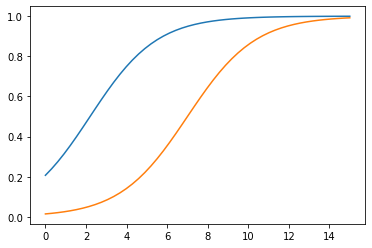

In [45]:
x = np.linspace(0, 1.5)
y1 = 1/(1+np.exp(-6.1*(x - 0.22)))
y2 = 1/(1+np.exp(-6.0*(x-0.70)))
plt.plot(x*10, y1)
plt.plot(x*10, y2)

In [6]:
np.log10(data['median'].min()), np.log10(data['median'].max())

(2.580698985123864, 4.38223954718102)

In [7]:
np.mean(data['ub']>md_t2[protein]), np.sum(data['ub']>md_t2[protein]), 

(0.4965986394557823, 73)

In [8]:
((data['median']/md_t2[protein]-1)*100).head()

64511    33.957503
67261    33.957503
68361    33.346834
67811    33.346834
65611    31.528225
Name: median, dtype: float64

In [9]:
data['median'].head()

64511    24112.350456
67261    24112.350456
68361    24002.430197
67811    24002.430197
65611    23675.080545
Name: median, dtype: float64

In [11]:
data.loc[data['median'] > 15000, ['hp_ix', 'median', 'tica__dim', 'tica__lag', 'cluster__k', 
                                 'distances__steepness', 'distances__centre']]

,hp_ix,median,tica__dim,tica__lag,cluster__k,distances__steepness,distances__centre
64511,333,24112.350456,16,38,469,5.967568,0.700806
67261,331,24112.350456,17,38,459,5.967568,0.700806
68361,329,24002.430197,17,38,469,5.967568,0.700806
67811,332,24002.430197,17,38,489,5.967568,0.700806
65611,335,23675.080545,19,38,479,5.967568,0.700806
66161,338,23363.471334,19,38,469,5.967568,0.700806
63411,330,23363.471334,17,38,479,5.967568,0.700806
62861,336,22784.212602,18,38,469,5.967568,0.700806
63961,334,22371.078033,18,38,479,5.967568,0.700806
66711,339,20898.344072,16,55,469,5.967568,0.700806
